In [2]:
import os
import numpy as np
import pandas as pd

import pymatgen as pg


In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

In [4]:

def local_min(df):

    df['dy'] = df['Edis'].diff()

    df['sign_dy'] = np.sign(df['dy'])
    df['sign_change'] = df['sign_dy'].diff()

    # Indices of local maxima: derivative goes from negative (-1) to positive (+1)
    local_min_indices = df.index[(df['sign_change'] > 0)]

    if len(local_min_indices) == 0:
        print('No local min found')
        return None
    local_mins = df.loc[local_min_indices, ['cell_length', 'Edis']].reset_index(drop=True)

    return local_mins

def local_max(df):
    df['dy'] = df['Edis'].diff()

    df['sign_dy'] = np.sign(df['dy'])
    df['sign_change'] = df['sign_dy'].diff()
    
    # Indices of local maxima: derivative goes from negative (-1) to positive (+1)
    local_min_indices = df.index[(df['sign_change'] < 0)]

    if len(local_min_indices) == 0:
        print('No local max found')
        return None
    local_max = df.loc[local_min_indices, ['cell_length', 'Edis']].reset_index(drop=True)
    return local_max

In [5]:
def finding_diff(df):
    abs_max = df['Edis'].iloc[-1]
    max_val = local_max(df)
    min_val = local_min(df)

    if max_val is None or min_val is None:
        return 0
    
    diff = (abs_max + max_val['Edis'][0])/2 - min_val['Edis'][0]

    return diff

In [6]:
from pymatgen.core import Structure

In [7]:
#list all folders inside li_d3s
li_d3s = os.listdir("d3_calcs")

results = []

df = pd.DataFrame()
cnt=0
for items in li_d3s:
    cnt+=1
    #get the path of each folder
    path = os.path.join("d3_calcs", items)
    # print(items)
    
    #ignore .DS_Store
    if items == ".DS_Store":
        continue
    file = os.path.join(path, f'{items}.csv')
    struct_file = os.path.join(path, 'POSCAR')
    df = pd.read_csv(file)
    print(f"Reading {file}")
    # exract materials id from file name

    material_id = os.path.basename(file).split('.')[0].split('_')[1]
    print(f"Material ID: mp-{material_id}")
    struct = Structure.from_file(struct_file)
    sites = struct.num_sites
    
    # print(struct.composition['Li'])
    li_sites = struct.composition['K']
    counter_ion_sites = struct.composition[struct.composition.elements[1]]
    diff_energy = finding_diff(df)
    print(f'Composition {struct.composition}')
    print(f'diff per toal sites {diff_energy/sites}')
    print(f'diff per cation sites {diff_energy/li_sites}')
    print('-----------------------------------')

    result = {
        "Symbol": struct.composition.elements[0] if struct.composition.elements[0].symbol != 'K' else struct.composition.elements[1],
        "Structure": struct.composition,
        "Total Sites": sites,
        "Cation Sites": li_sites,
        "Counter Ion Sites": counter_ion_sites,
        "Diff Energy": diff_energy,
        "Diff per Total Sites": diff_energy/sites,
        "Diff per Cation Sites": diff_energy/li_sites,
        "Diff per Counter Ion Sites": diff_energy/counter_ion_sites,
        "Volume": struct.volume,
        "mid": material_id,
        "Composition": str(struct.composition)
    }

    results.append(result)
print(f'total structure analysed = {cnt}')
    

Reading d3_calcs/K3Tb_1185125/K3Tb_1185125.csv
Material ID: mp-1185125
Composition K6 Tb2
diff per toal sites 0.0043372653882155065
diff per cation sites 0.005783020517620675
-----------------------------------
Reading d3_calcs/K2S_559278/K2S_559278.csv
Material ID: mp-559278
Composition K4 S2
diff per toal sites 0.007813655507845694
diff per cation sites 0.01172048326176854
-----------------------------------
Reading d3_calcs/KIn3_1185104/KIn3_1185104.csv
Material ID: mp-1185104
Composition K1 In3
diff per toal sites 0.005070008630208962
diff per cation sites 0.02028003452083585
-----------------------------------
Reading d3_calcs/KRb3_1185080/KRb3_1185080.csv
Material ID: mp-1185080
Composition K1 Rb3
diff per toal sites 0.002107777981329687
diff per cation sites 0.008431111925318749
-----------------------------------
Reading d3_calcs/K4Pb9_680443/K4Pb9_680443.csv
Material ID: mp-680443
Composition K16 Pb36
diff per toal sites 0.005568712697952432
diff per cation sites 0.01809831626

### for individual elements

In [8]:

file = "../Li_bulk/Li_fcc/Li_fcc.csv"
struct_file = '../Li_bulk/Li_fcc/POSCAR'

df = pd.read_csv(file)
print(f"Reading {file}")
struct = Structure.from_file(struct_file)
sites = struct.num_sites
# print(struct.composition['Li'])
li_sites = struct.composition['K']

diff_energy = finding_diff(df)
print(f'Composition {struct.composition}')
print(f'diff per toal sites {diff_energy/sites}')
print(f'diff per Li sites {diff_energy/li_sites}')
print('-----------------------------------')
result = {
    "Symbol": struct.composition.elements[0] if struct.composition.elements[0].symbol != 'K' else struct.composition.elements[1],
    "Structure": struct.composition,
    "Total Sites": sites,
    "Li Sites": li_sites,
    "Diff Energy": diff_energy,
    "Diff per Total Sites": diff_energy/sites,
    "Diff per Li Sites": diff_energy/li_sites,
    "Composition": str(struct.composition)
}

result

FileNotFoundError: [Errno 2] No such file or directory: '../Li_bulk/Li_fcc/Li_fcc.csv'

In [16]:
results_df = pd.DataFrame(results)
results_df.to_csv("analysis_results.csv", index=False)

print(f"Total structures analysed = {cnt}")
# print("Results saved to analysis_results.csv")

results_df['Diff per Total Sites'].max()*1000

Total structures analysed = 321


18.6772383644176

### Thougest part is to make the Feature functions data 


In [34]:
props = pd.read_csv('../mixed_comps/PubChemElements_all.csv')
polarisability = pd.read_csv('../elements_polarizability.csv')

props = props[['Symbol', 'AtomicMass','AtomicRadius','Electronegativity','IonizationEnergy','ElectronAffinity']]

In [35]:
all_props = []
cnt = 0
for items in li_d3s:
    # cnt+=1
    #get the path of each folder
    path = os.path.join("d3_calcs", items)
    # print(items)
    
    #ignore .DS_Store
    if items == ".DS_Store":
        continue
    file = os.path.join(path, f'{items}.csv')
    struct_file = os.path.join(path, 'POSCAR')


    struct = Structure.from_file(struct_file)
    sites = struct.num_sites

    vol_site = struct.volume/sites
    # print(density)

    # print(struct.composition.elements[1])

    elem = struct.composition.elements[0] if(struct.composition.elements[1].symbol == 'K')  else struct.composition.elements[1]

    print(elem)
    # print(elem.symbol == 'Ge')

    matched_row = props[props['Symbol'] == elem.symbol]
    elem_polarizability = polarisability[polarisability['Symbol'] == elem.symbol]

    space_group = struct.get_space_group_info()


    
    print(struct.composition.reduced_formula)
    # DiffPerLi = results_df[results_df['Symbol'] == elem.symbol]
    # matched_row.add('Polarizability', elem_polarizability['Polarizability'].values[0])
    matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
    matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
    matched_row['results_per_cation'] = results_df['Diff per Cation Sites'][cnt]*1000
    # matched_row['TotalSites'] = results_df['Total Sites'][cnt]
    matched_row['CationSites'] = results_df['Cation Sites'][cnt]/sites
    matched_row['CounterIonSites'] = results_df['Counter Ion Sites'][cnt]/sites
    matched_row['results_per_counter_ion'] = results_df['Diff per Counter Ion Sites'][cnt]
    # matched_row['Diff per Li Sites'] = DiffPerLi['Diff per Li Sites'].values[0]
    matched_row['res_per_volm_per_site'] = results_df['Diff per Total Sites'][cnt]/vol_site
    matched_row['Result']=  results_df['Diff per Total Sites'][cnt]/vol_site*1000
    matched_row['SpaceGroup'] = space_group[0]
    matched_row['SpaceGroupNumber'] = space_group[1]
    matched_row['Total Sites'] = sites
    matched_row['Volume'] = results_df['Volume'][cnt]
    matched_row['mid'] = results_df['mid'][cnt]
    matched_row["Reduced Formula"] = struct.composition.reduced_formula
    all_props.append(matched_row)

    cnt+=1

all_props_df = pd.concat(all_props, ignore_index=True)
    

Tb
K3Tb
S
K2S
In
KIn3
Rb
KRb3
Pb
K4Pb9
Rh
K3Rh
N
KN2
Nd
K3Nd
Pm
KPm
Hg
K3Hg11
Os
K3Os
Li
K3Li
Eu
KEu3
Cs
CsK3
Rh
K3Rh
Sm
K3Sm
Lu
KLu
Tb
K3Tb
Ge
KGe
Ir
K3Ir
Dy
K3Dy
Ga
K3Ga
Tl
K3Tl
Ca
KCa3
Ta
K3Ta
As
KAs
Pu
KPu
Bi
K3Bi
Sb
K5Sb4
C
KC2
I
KI
Rh
K3Rh
Tm
K3Tm
S
KS
Y
K3Y
Ba
K3Ba
S
KS
Yb
KYb3
Cl
KCl3
Sr
KSr3
Eu
K3Eu
Tl
KTl2


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_57631/1739482315.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_57631/1739482315.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_57631/1739482315.py:41: SettingWith

Dy
K3Dy
Na
K3Na
Bi
K3Bi
Os
K3Os
P
K2P3
Mg
KMg3
Ge
KGe
Rb
KRb3
Tc
K2Tc
Mg
KMg3
O
KO2
Cs
CsK3
Li
KLi3
C
KC
Na
KNa2
N
KN2
Ru
K3Ru
I
KI
Mg
KMg3
Ag
K2Ag
U
KU3
Mo
K3Mo
Se
KSe3
Bi
K3Bi2
Se
K5Se3
Li
KLi3
Ce
K3Ce
Re
K2Re
Ho
K3Ho
Cd
K3Cd
Mg
K3Mg
Hg
KHg3
Na
K3Na
Hg
KHg3
Sn
KSn2
Cs
CsK
Nd
K3Nd
Ac
K3Ac
I
KI
Ac
KAc3


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_57631/1739482315.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_57631/1739482315.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_57631/1739482315.py:41: SettingWith

Tm
KTm
Y
KY
N
KN
Sr
KSr3
Lu
K3Lu
O
K2O
La
KLa3
Yb
K3Yb
Hg
K7Hg31
C
KC2
Ba
KBa3
N
KN
Mn
K3Mn
Br
KBr
As
K5As4
Sb
K3Sb
Ac
KAc3
Tl
KTl
Nd
KNd
Cd
KCd3
Tb
K3Tb
Zr
K3Zr
C
KC10
Co
KCo
O
KO2
Th
K3Th
O
K2O
Pt
KPt
Sm
KSm
Y
K3Y


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_57631/1739482315.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_57631/1739482315.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_57631/1739482315.py:41: SettingWith

Li
K3Li
Tl
K3Tl
Cs
CsK2
Th
K3Th
Eu
KEu3
C
KC2
Hg
K3Hg
Y
K3Y
Cs
CsK
F
KF3
Tm
K3Tm
P
KP
O
KO2
Sr
K3Sr
Mn
K3Mn
Mn
K3Mn
Ag
K3Ag
O
K2O
Cs
CsK3
P
K2P3
O
KO2
Fe
K4Fe
Ba
KBa3
Tl
K6Tl17
O
K2O2
O
KO2
Sn
K6Sn25
Nb
K3Nb
O
K2O
Co
K3Co
Co
K3Co
Pb
KPb3
Te
KTe3
N
KN3
Sr
KSr3
Pm
K3Pm
Zn
K3Zn
Sb
KSb3
O
K2O
Pb
KPb2
Ga
K3Ga
Mg
KMg7
In
K3In
Be
K3Be
Sm
K3Sm
Co
KCo


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_57631/1739482315.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_57631/1739482315.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_57631/1739482315.py:41: SettingWith

O
KO3
Er
K3Er
Zr
K3Zr
O
KO2
Cs
Cs3K
Cu
K3Cu
Ga
K3Ga
La
K5La2
Cr
K3Cr
Zn
K3Zn
Na
K3Na
Eu
KEu3
Sn
KSn3
C
KC
Cr
K3Cr
Ir
K3Ir
Co
K3Co
Bi
KBi3
N
KN
Pm
K3Pm
V
K3V
Ta
K3Ta
Mn
K3Mn
W
K3W
Ca
KCa3
Zn
K3Zn
Sm
KSm3
In
K3In
Tc
K3Tc
Co
KCo
Mo
K3Mo


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_57631/1739482315.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_57631/1739482315.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_57631/1739482315.py:41: SettingWith

Nd
KNd3
Sn
K3Sn
Si
K3Si
P
KP
Yb
KYb3
B
K11B62
O
KO3
B
KB
Eu
K3Eu
Hg
K3Hg
Rb
KRb3
Pd
K2Pd
Mg
K3Mg
Rh
K3Rh
Tc
K2Tc
Hf
K3Hf
O
KO2
Ca
K3Ca
Ce
KCe3
V
K3V
O
K2O
Cl
KCl
Tm
K3Tm
Hg
KHg3
Sn
K2Sn
Pr
K3Pr
S
KS
Dy
K3Dy
Bi
K4Bi
N
K3N
Pm
KPm3
Ru
K3Ru


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_57631/1739482315.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_57631/1739482315.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_57631/1739482315.py:41: SettingWith

Zr
K3Zr
Zr
K2Zr
O
KO2
Sc
K3Sc
W
K3W
C
KC2
Cd
K3Cd
O
K2O
U
K3U
C
KC60
I
KI
Re
K3Re
Li
K3Li
Rh
K3Rh
N
KN2
Pm
KPm3
Rb
K3Rb
Th
K3Th
Hf
K3Hf
Se
KSe
Si
KSi
F
KF
Ga
K2Ga3
S
KS
Rb
K3Rb
Hg
KHg3
Cs
Cs6K7
O
K2O
C
KC
Ag
KAg2
C
KC2
Pr
KPr3
Se
KSe
Ca
K3Ca
In
K3In
F
KF5


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_57631/1739482315.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_57631/1739482315.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_57631/1739482315.py:41: SettingWith

Al
K3Al
Tc
K2Tc
Mg
K3Mg
Er
K3Er
O
K2O
Fe
KFe
Sr
K3Sr
Ba
K3Ba
Sb
K5Sb4
C
K4C
Al
K3Al
Cr
K3Cr
H
KH3
Ge
K4Ge23
Tl
K3Tl
Ge
K3Ge
Se
K57Se34
Se
K2Se5
C
K2C
Ti
K3Ti
Mo
K3Mo
Se
KSe3
O
K2O
Tl
KTl
Si
KSi
Rb
KRb3
O
K2O
Ti
K3Ti
Si
K4Si23
Rb
K3Rb
Pu
KPu
O
K2O2
Ca
KCa3
As
KAs
Pd
K3Pd
Hf
K3Hf
B
K3B17
F
KF3
Th
KTh3
Tc
K3Tc
Mg
KMg15
Si
K15Si92
Pt
KPt3
Pr
K3Pr
La
KLa3
Nb
K3Nb
Cd
K3Cd
Ga
KGa
Tl
KTl3
C
KC
O
KO2
Re
K2Re
Pr
KPr3
Re
K3Re
Sr
K3Sr
P
KP
Ho
K3Ho
Ce
K3Ce
S
K2S5
Cs
CsK3
Bi
K5Bi4
Te
KTe
Ba
K3Ba


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_57631/1739482315.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_57631/1739482315.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_57631/1739482315.py:41: SettingWith

In [36]:
all_props_df


,Symbol,AtomicMass,AtomicRadius,Electronegativity,IonizationEnergy,ElectronAffinity,Polarizability,results_per_total,results_per_cation,CationSites,CounterIonSites,results_per_counter_ion,res_per_volm_per_site,Result,SpaceGroup,SpaceGroupNumber,Total Sites,Volume,mid,Reduced Formula
0,Tb,158.925350,221.0,NaN,5.864,NaN,170.0,4.337265,5.783021,0.750000,0.250000,0.017349,0.000076,0.075517,P6_3/mmc,194,8,459.471608,1185125,K3Tb
1,S,32.070000,180.0,2.58,10.360,2.077,19.4,7.813656,11.720483,0.666667,0.333333,0.023441,0.000264,0.263950,P6_3/mmc,194,6,177.616848,559278,K2S
2,In,114.818000,193.0,1.78,5.786,0.300,65.0,5.070009,20.280035,0.250000,0.750000,0.006760,0.000169,0.169398,Fm-3m,225,4,119.718038,1185104,KIn3
3,Rb,85.468000,303.0,0.82,4.177,0.468,319.8,2.107778,8.431112,0.250000,0.750000,0.002810,0.000023,0.023148,Pm-3m,221,4,364.221518,1185080,KRb3
4,Pb,207.000000,202.0,2.33,7.417,0.360,57.0,5.568713,18.098316,0.307692,0.692308,0.008044,0.000139,0.138729,P2_1/m,11,52,2087.328498,680443,K4Pb9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,S,32.070000,180.0,2.58,10.360,2.077,19.4,2.996255,10.486891,0.285714,0.714286,0.004195,0.000097,0.096999,P2_12_12_1,19,28,864.909095,672372,K2S5
316,Cs,132.905452,343.0,0.79,3.894,0.472,400.9,11.041731,14.722308,0.750000,0.750000,0.014722,0.000129,0.129397,Fm-3m,225,4,341.328208,1185554,CsK3
317,Bi,208.980400,207.0,2.02,7.289,0.946,53.0,7.198462,12.957232,0.555556,0.444444,0.016197,0.000168,0.167848,Cm,8,9,385.981993,1223773,K5Bi4
318,Te,127.600000,206.0,2.10,9.010,1.971,38.0,6.825826,13.651651,0.500000,0.500000,0.013652,0.000158,0.157881,P-62m,189,12,518.806543,1554,KTe


In [37]:
all_props_df.to_csv('all_props_new.csv', index=False)

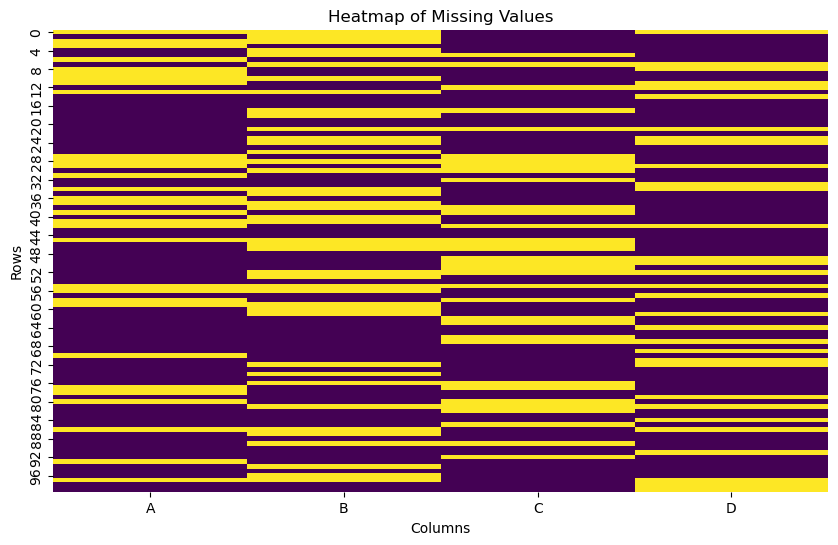

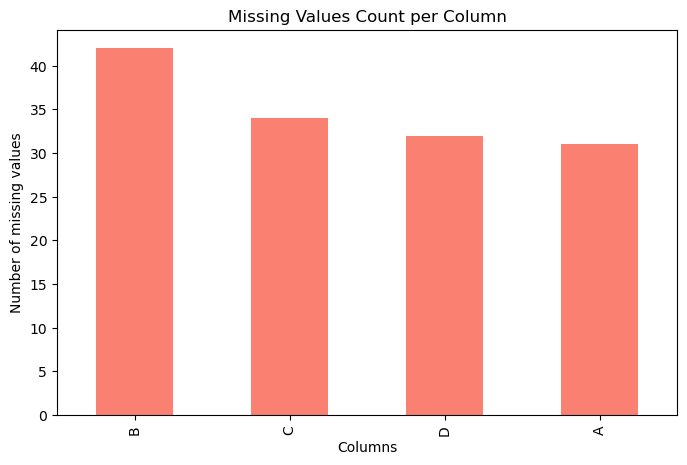

In [ ]:
# show me some graphs to analyze NaN values

import matplotlib.pyplot as plt
import seaborn as sns

# Example DataFrame with NaN values (replace this with your actual DataFrame)
# For demonstration, we're creating a DataFrame with some random missing values.
np.random.seed(42)
data = {
    'A': np.random.choice([1, 2, np.nan], size=100),
    'B': np.random.choice([3, 4, np.nan], size=100),
    'C': np.random.choice([5, 6, np.nan], size=100),
    'D': np.random.choice([7, 8, np.nan], size=100)
}
df = pd.DataFrame(data)

# -------------------------------
# Plot 1: Heatmap of Missing Values
# -------------------------------
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Heatmap of Missing Values")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

# -------------------------------
# Plot 2: Bar Chart of Missing Values per Column
# -------------------------------
missing_counts = df.isnull().sum().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
missing_counts.plot(kind="bar", color='salmon')
plt.ylabel("Number of missing values")
plt.xlabel("Columns")
plt.title("Missing Values Count per Column")
plt.show()

In [ ]:
all_props_df.fillna(0, inplace=True)


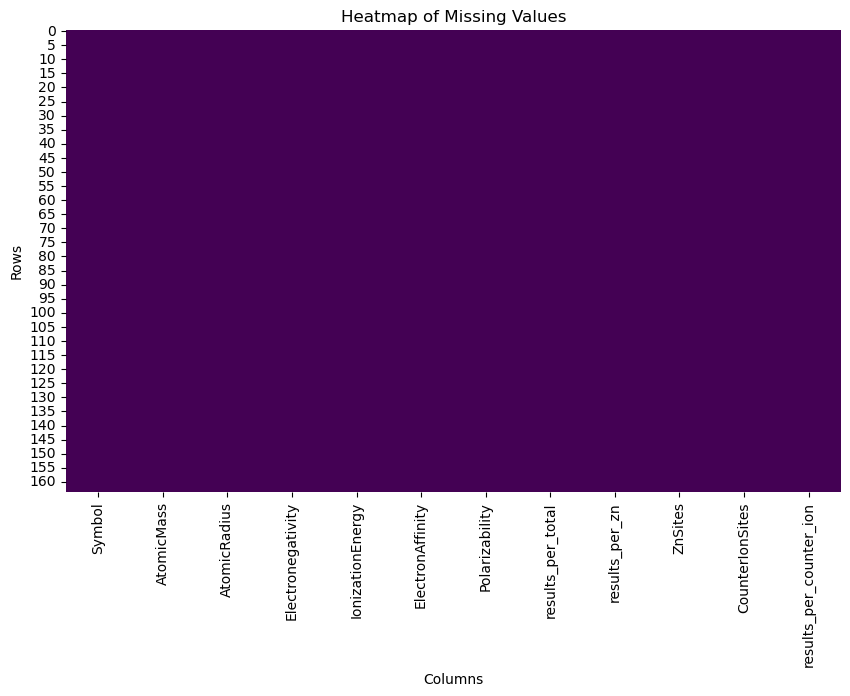

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(all_props_df.isnull(), cbar=False, cmap="viridis")
plt.title("Heatmap of Missing Values")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

In [ ]:
# all_props_df.to_csv('all_props_new.csv', index=False)
all_props_df = pd.read_csv('all_props.csv')

all_props_df

,Symbol,AtomicMass,AtomicRadius,Electronegativity,IonizationEnergy,ElectronAffinity,Polarizability,results_per_total,results_per_zn,ZnSites,CounterIonSites,results_per_counter_ion
0,Zn,65.40,139.0,1.65,9.394,NaN,38.67,0.012687,0.038062,1.0,1.0,0.038062
1,Zn,65.40,139.0,1.65,9.394,NaN,38.67,0.008223,0.008855,26.0,26.0,0.008855
2,Zn,65.40,139.0,1.65,9.394,NaN,38.67,0.011320,0.016980,4.0,4.0,0.016980
3,Zn,65.40,139.0,1.65,9.394,NaN,38.67,0.009284,0.011140,10.0,10.0,0.011140
4,Zn,65.40,139.0,1.65,9.394,NaN,38.67,0.010972,0.029258,6.0,6.0,0.029258
...,...,...,...,...,...,...,...,...,...,...,...,...
159,Se,78.97,190.0,2.55,9.752,2.021,28.90,0.002714,0.005429,1.0,1.0,0.005429
160,S,32.07,180.0,2.58,10.360,2.077,19.40,0.002662,0.005324,28.0,28.0,0.005324
161,Te,127.60,206.0,2.10,9.010,1.971,38.00,0.002715,0.005429,3.0,3.0,0.005429
162,Zn,65.40,139.0,1.65,9.394,NaN,38.67,0.015521,0.023282,4.0,4.0,0.023282
